In [1]:
# set up python environment
import pyreadr
import pandas as pd
import os
from os import listdir
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

os.chdir('/Users/xiaodanxu/Library/CloudStorage/GoogleDrive-arielinseu@gmail.com/My Drive/GEMS/validation')

plt.style.use('ggplot')

In [2]:
# define validation inputs and parameters
mode_choice_data_dir = 'mode_choice/'
supplement_data_dir = 'nhts_raw/'
output_plot_dir = 'plot/'

# gems_output_dir_2 = 'GEMS_output/LA_local/'
param_dir = 'parameter/'

mode_choice_data_source = 'NHTS/NHTS_tract_mode.split.National.RData'
mode_choice_geotype_id = 'NHTS/nhts_no_ids_1hrtimebins_with_imputation.csv'
mode_choice_microtype_id = 'NHTS/NHTS_tract_od.tr.purpose.National_transgeo.RData'
supplement_data_source = 'trippub.csv'
household_data_source = 'hhpub.csv'

time_period_file = 'TimePeriods_TEMPO.csv'
# CA_houshold_file = 'household_ca.RData'
national_geoid_lookup_file = 'ccst_geoid_key_tranps_geo_with_imputation.csv'
distance_matrix = 'distance_matrix_by_tracts.csv'

nSubBins = 1
mps_to_mph = 2.23694
mode_lookup = {1: 'walk', 2: 'bike', 3: 'auto', 4: 'auto', 5: 'auto', 6: 'auto', 7: 'scooter', 8: 'scooter', 9: 'auto', 10: 'bus', 11: 'bus',
              12: 'bus', 13: 'bus', 14: 'bus', 15: 'rail', 16: 'rail', 17: 'taxi', 18: 'auto', 19: 'other',
              20: 'other', 97: 'other'}


In [3]:
# load NHTS dataset
mode_choice_data = pyreadr.read_r(mode_choice_data_dir + mode_choice_data_source)
mode_choice_data_df = mode_choice_data['mode.split']
print(mode_choice_data_df.columns)
od_microtype_data = pyreadr.read_r(mode_choice_data_dir + mode_choice_microtype_id)
od_microtype_data_df = od_microtype_data['od.tr.purpose']
print(od_microtype_data_df.columns)

mode_choice_additional = pd.read_csv(supplement_data_dir + supplement_data_source, sep = ',')
print(mode_choice_additional.columns)
household_weights = pd.read_csv(supplement_data_dir + household_data_source, sep = ',')
print(household_weights.columns)

mode_choice_geotype_df = pd.read_csv(mode_choice_data_dir + mode_choice_geotype_id, sep = ',')
print(mode_choice_geotype_df.columns)

Index(['houseid', 'personid', 'tdtrpnum', 'trptrans', 'home_geoid',
       'spatial_id', 'fips_st', 'st_code', 'state', 'cty', 'ctyname', 'cbsa',
       'cbsaname', 'population', 'hholds_total', 'pop_region', 'hu_region',
       'aland2017', 'awater2017', 'area_land_region', 'area_water_region',
       'home_geotype', 'home_microtype', 'geo_micro_type', 'microtype',
       'geotype', 'wtperfin'],
      dtype='object')
Index(['HOUSEID', 'PERSONID', 'TDTRPNUM', 'whytrp1s', 'ORIG_COUNTRY',
       'o_geoid', 'DEST_COUNTRY', 'd_geoid', 'o_microtype', 'o_geotype',
       'd_microtype', 'd_geotype'],
      dtype='object')
Index(['HOUSEID', 'PERSONID', 'TDTRPNUM', 'STRTTIME', 'ENDTIME', 'TRVLCMIN',
       'TRPMILES', 'TRPTRANS', 'TRPACCMP', 'TRPHHACC',
       ...
       'R_AGE_IMP', 'R_SEX_IMP', 'HBHUR', 'HTHTNRNT', 'HTPPOPDN', 'HTRESDN',
       'HTEEMPDN', 'HBHTNRNT', 'HBPPOPDN', 'HBRESDN'],
      dtype='object', length=105)
Index(['HOUSEID', 'TRAVDAY', 'SAMPSTRAT', 'HOMEOWN', 'HHSIZE', 'HHVE

In [4]:
# generate NHTS variables
list_of_used_gems_variables = ['HOUSEID', 'PERSONID', 'TDTRPNUM', 'HHFAMINC', 
                               'WHYTRP1S', 'TRPMILES', 'STRTTIME', 'ENDTIME',
                               'TRIPPURP']

list_of_od_variables = ['HOUSEID', 'PERSONID', 'TDTRPNUM', 'ORIG_COUNTRY',
       'o_geoid', 'DEST_COUNTRY', 'd_geoid', 'o_microtype', 'o_geotype',
       'd_microtype', 'd_geotype']

list_of_hh_variables = ['HOUSEID', 'WTHHFIN', 'HBHUR']

list_of_geotype_variables = ['HOUSEID', 'h_geotype']

def gems_attributes_generator(NHTS_data, distance_bins, distance_bin_labels):
    NHTS_data.loc[:, 'populationGroupType'] = 'high-income'
    NHTS_data.loc[NHTS_data['hhfaminc']<= 5, 'populationGroupType'] = 'low-income'
    NHTS_data.loc[NHTS_data['hhfaminc'].isin([6,7,8]), 'populationGroupType'] = 'medium-income'
    NHTS_data.loc[:, 'trip_purpose'] = 'other'
    NHTS_data.loc[NHTS_data['whytrp1s'] == 1, 'trip_purpose'] = 'home'
    NHTS_data.loc[NHTS_data['whytrp1s'] == 10, 'trip_purpose'] = 'work'
    NHTS_data.loc[NHTS_data['whytrp1s'].isin([40, 50, 80]), 'trip_purpose'] = 'leisure'
    NHTS_data.loc[NHTS_data['whytrp1s'] == 20, 'trip_purpose'] = 'school'
    NHTS_data.loc[NHTS_data['whytrp1s'] == 30, 'trip_purpose'] = 'medical'
#     NHTS_data.loc[:, 'tripPurpose'] = 'nonwork'
#     NHTS_data.loc[NHTS_data['whytrp1s'].isin(work_trips), 'tripPurpose'] = 'work'    
    NHTS_data.loc[:, 'distanceBin'] = pd.cut(NHTS_data.loc[:, 'trpmiles'], distance_bins, 
                                                      labels = distance_bin_labels, ordered = False)
    return(NHTS_data)

def travel_time_calculator(NHTS_data):
    NHTS_data.loc[:, 'start hour'] = NHTS_data.loc[:, 'strttime'] / 100
    NHTS_data.loc[:, 'start hour'] = NHTS_data.loc[:, 'start hour'].astype(int)
    NHTS_data.loc[:, 'start hour'] = NHTS_data.loc[:, 'start hour'] + \
    (NHTS_data.loc[:, 'strttime'] %100) / 60.0

    NHTS_data.loc[:, 'end hour'] = NHTS_data.loc[:, 'endtime'] / 100
    NHTS_data.loc[:, 'end hour'] = NHTS_data.loc[:, 'end hour'].astype(int)
    NHTS_data.loc[:, 'end hour'] = NHTS_data.loc[:, 'end hour'] + \
    (NHTS_data.loc[:, 'endtime'] %100) / 60.0

    NHTS_data.loc[:, 'travel time'] = NHTS_data.loc[:, 'end hour'] - NHTS_data.loc[:, 'start hour']
    NHTS_data.loc[(NHTS_data['travel time'] < 0) & (NHTS_data['trpmiles'] < 1), 'travel time'] = 0
    NHTS_data.loc[NHTS_data['travel time'] < 0, 'travel time'] += 24
    return(NHTS_data)
    

mode_choice_additional = mode_choice_additional.loc[:, list_of_used_gems_variables]
mode_choice_additional.columns= mode_choice_additional.columns.str.lower()
mode_choice_data_df = pd.merge(mode_choice_data_df, mode_choice_additional, 
                               on = ['houseid', 'personid', 'tdtrpnum'], how = 'left')

mode_choice_geotype_df = mode_choice_geotype_df.loc[:, list_of_geotype_variables]
mode_choice_geotype_df.columns= mode_choice_geotype_df.columns.str.lower()
mode_choice_geotype_df = mode_choice_geotype_df.drop_duplicates(keep = 'first')
mode_choice_data_df = pd.merge(mode_choice_data_df, mode_choice_geotype_df, 
                               on = ['houseid'], how = 'left')

od_variable_df = od_microtype_data_df.loc[:, list_of_od_variables]
od_variable_df.columns= od_variable_df.columns.str.lower()
mode_choice_data_df = pd.merge(mode_choice_data_df, od_variable_df, 
                               on = ['houseid', 'personid', 'tdtrpnum'], how = 'left')

hh_variable_df = household_weights.loc[:, list_of_hh_variables]
hh_variable_df.columns= hh_variable_df.columns.str.lower()
mode_choice_data_df = pd.merge(mode_choice_data_df, hh_variable_df, 
                               on = ['houseid'], how = 'left')

distance_bins = [0, 1.3, 3, 5, 8, 10, 20, mode_choice_data_df['trpmiles'].max()]
distance_bin_labels = ['1_1', '1_2', '1_3', '2_1', '2_2', '3_0', '4_0']

mode_choice_data_df = gems_attributes_generator(mode_choice_data_df, distance_bins, distance_bin_labels)
mode_choice_data_df = travel_time_calculator(mode_choice_data_df)
print(mode_choice_data_df.trip_purpose.unique())
mode_choice_data_df.head(5)

['school' 'home' 'work' 'leisure' 'medical' 'other']


,houseid,personid,tdtrpnum,trptrans,home_geoid,spatial_id,fips_st,st_code,state,cty,...,d_microtype,d_geotype,wthhfin,hbhur,populationGroupType,trip_purpose,distanceBin,start hour,end hour,travel time
0,30000007,1,1,3,3.719100e+10,24140,37,NC,North Carolina,37191,...,4,E,187.31432,T,medium-income,school,2_1,10.000000,10.25,0.250000
1,30000007,1,2,3,3.719100e+10,24140,37,NC,North Carolina,37191,...,4,E,187.31432,T,medium-income,home,2_1,15.166667,15.50,0.333333
2,30000007,2,1,6,3.719100e+10,24140,37,NC,North Carolina,37191,...,4,E,187.31432,T,medium-income,home,4_0,7.000000,9.00,2.000000
3,30000007,2,2,6,3.719100e+10,24140,37,NC,North Carolina,37191,...,3,C,187.31432,T,medium-income,work,4_0,18.000000,20.50,2.500000
4,30000007,3,1,3,3.719100e+10,24140,37,NC,North Carolina,37191,...,5,E,187.31432,T,medium-income,school,1_2,8.750000,9.00,0.250000


In [5]:
# generate population
national_geoid_lookup = pd.read_csv('parameter/' + national_geoid_lookup_file, sep = ',')

list_of_population_variables= ['houseid', 'home_geoid', 
                               'populationGroupType',
                              'wthhfin']
population_trips = mode_choice_data_df.loc[:, list_of_population_variables]
population_trips = population_trips.drop_duplicates()
population_trips = pd.merge(population_trips, national_geoid_lookup,
                            left_on = 'home_geoid', right_on = 'GEOID',
                            how = 'left')
population_by_tract = population_trips.groupby(['st_code', 'geotype', 
                               'microtype', 'populationGroupType'])[['wthhfin']].sum()
population_by_tract.columns =['NHTS_households']
population_by_tract = population_by_tract.reset_index()
# population_by_tract.loc[:, 'home_geoid'] = population_by_tract.loc[:, 'home_geoid'].astype(int)
print(len(population_by_tract))
population_by_tract.to_csv(supplement_data_dir + 'NHTS_population.csv', index = False)

2263


In [6]:
mode_choice_data_df.loc[:, 'mode'] = mode_choice_data_df.loc[:, 'trptrans'].map(mode_lookup)

time_period_spec = pd.read_csv(param_dir + time_period_file, sep = ',')
time_period_spec.loc[:, 'Interval'] = time_period_spec.loc[:, 'DurationInHours'] / nSubBins
time_period_spec.loc[:, 'EndTime']  = time_period_spec.loc[:, 'DurationInHours'].cumsum()
time_labels = time_period_spec['TimePeriodID'].tolist()
cut_off_points = time_period_spec.loc[:, 'EndTime'].tolist() 
cut_off_points.insert(0, 0)
mode_choice_data_df.loc[:, 'time period'] = pd.cut(mode_choice_data_df.loc[:, 'start hour'], cut_off_points, 
                                                  labels = time_labels, ordered = False, right = False)


In [7]:
mode_choice_data_df.loc[:, 'h_origin'] = 1 * (mode_choice_data_df.loc[:, 'o_geoid'] == mode_choice_data_df.loc[:, 'home_geoid']) + \
0 * (mode_choice_data_df.loc[:, 'o_geoid'] != mode_choice_data_df.loc[:, 'home_geoid'])

mode_choice_data_df.loc[:, 'h_dest'] = 1 * (mode_choice_data_df.loc[:, 'd_geoid'] == mode_choice_data_df.loc[:, 'home_geoid']) + \
0 * (mode_choice_data_df.loc[:, 'd_geoid'] != mode_choice_data_df.loc[:, 'home_geoid'])

mode_choice_data_df.loc[:, 'nhb'] = 1 * (mode_choice_data_df.loc[:, 'trippurp'] == 'NHB') + \
0 * (mode_choice_data_df.loc[:, 'trippurp'] != 'NHB')


mode_choice_data_df.loc[:, 'trip_tag'] = 'nhb'
mode_choice_data_df.loc[mode_choice_data_df['h_origin'] == 1, 'trip_tag'] = 'origin'
mode_choice_data_df.loc[mode_choice_data_df['h_dest'] == 1, 'trip_tag'] = 'dest'
print(mode_choice_data_df.trip_tag.unique())
mode_choice_data_df.loc[:, ['h_origin', 'h_dest', 'nhb', 'trip_tag']].head(10)

# assign tour end micro-geotype ID
mode_choice_data_df.loc[:, 'dest_geotype'] = \
mode_choice_data_df.loc[:, 'o_geotype']
mode_choice_data_df.loc[:, 'dest_microtype'] = \
mode_choice_data_df.loc[:, 'o_microtype']
mode_choice_data_df.loc[:, 'dest_geoid'] = \
mode_choice_data_df.loc[:, 'o_geoid']

mode_choice_data_df.loc[:, 'orig_geotype'] = \
mode_choice_data_df.loc[:, 'd_geotype']
mode_choice_data_df.loc[:, 'orig_microtype'] = \
mode_choice_data_df.loc[:, 'd_microtype']
mode_choice_data_df.loc[:, 'orig_geoid'] = \
mode_choice_data_df.loc[:, 'd_geoid']

criteria1 = mode_choice_data_df['trip_tag'].isin(['origin', 'nhb'])

mode_choice_data_df.loc[criteria1, 'dest_geotype'] = \
mode_choice_data_df.loc[criteria1, 'd_geotype']
mode_choice_data_df.loc[criteria1, 'dest_microtype'] = \
mode_choice_data_df.loc[criteria1, 'd_microtype']
mode_choice_data_df.loc[criteria1, 'dest_geoid'] = \
mode_choice_data_df.loc[criteria1, 'd_geoid']

mode_choice_data_df.loc[criteria1, 'orig_geotype'] = \
mode_choice_data_df.loc[criteria1, 'd_geotype']
mode_choice_data_df.loc[criteria1, 'orig_microtype'] = \
mode_choice_data_df.loc[criteria1, 'd_microtype']
mode_choice_data_df.loc[criteria1, 'orig_geoid'] = \
mode_choice_data_df.loc[criteria1, 'o_geoid']

['origin' 'dest' 'nhb']


In [10]:
print(mode_choice_data_df['orig_geoid'].isna().sum())
print(mode_choice_data_df['dest_geoid'].isna().sum())
print(mode_choice_data_df['d_geoid'].isna().sum())
print(mode_choice_data_df['o_geoid'].isna().sum())

132
262
188
206


In [14]:
# print(national_geoid_lookup.columns)
# print(mode_choice_data_df.columns)
national_geoid_lookup_short = national_geoid_lookup[['GEOID', 'st_code', 'state']]
national_geoid_lookup_short['GEOID'] = \
national_geoid_lookup_short['GEOID'].astype(int)
national_geoid_lookup_short.columns = ['GEOID', 'dest_st_code', 'dest_state']
mode_choice_data_df = mode_choice_data_df.dropna(subset = ['dest_geoid', 'orig_geoid'])
mode_choice_data_df[['dest_geoid', 'orig_geoid']] = \
mode_choice_data_df[['dest_geoid', 'orig_geoid']].astype(int)
mode_choice_data_with_st = pd.merge(mode_choice_data_df,
                              national_geoid_lookup_short,
                              left_on = 'dest_geoid',
                              right_on = 'GEOID',
                              how = 'left')

mode_choice_data_with_st = mode_choice_data_with_st.drop(columns = ['GEOID'])
national_geoid_lookup_short.columns = ['GEOID', 'orig_st_code', 'orig_state']
mode_choice_data_with_st = pd.merge(mode_choice_data_with_st,
                              national_geoid_lookup_short,
                              left_on = 'orig_geoid',
                              right_on = 'GEOID',
                              how = 'left')
mode_choice_data_with_st = mode_choice_data_with_st.drop(columns = ['GEOID'])

car_data_df = mode_choice_data_with_st.loc[mode_choice_data_with_st['mode'] == 'auto']
spillover_criteria = (car_data_df['st_code'] != car_data_df['dest_st_code']) | \
(car_data_df['st_code'] != car_data_df['orig_st_code'])

spillover_auto_trip_df = \
car_data_df.loc[spillover_criteria]

# spillover_auto_trip_df_p2 = car_data_df.loc[car_data_df['trpmiles']> 100]
# spillover_auto_trip_df = pd.concat([spillover_auto_trip_df, 
#                                     spillover_auto_trip_df_p2])

small_state_to_exclude = ['NY', 'DE', 'NJ', 'RI', 'VA', 'MD', 'DC', 'CT', 'NH']
spillover_auto_trip_df = \
spillover_auto_trip_df[~spillover_auto_trip_df['st_code'].isin(small_state_to_exclude)]
print(len(spillover_auto_trip_df))
# print(spillover_auto_trip_df.st_code.unique())
spillover_auto_trip_df.head(5)

22723


,houseid,personid,tdtrpnum,trptrans,home_geoid,spatial_id,fips_st,st_code,state,cty,...,dest_geotype,dest_microtype,dest_geoid,orig_geotype,orig_microtype,orig_geoid,dest_st_code,dest_state,orig_st_code,orig_state
282,30000401,1,1,5,3.001300e+10,24500,30,MT,Montana,30013,...,B,2,8059011602,B,2,8035014503,CO,Colorado,CO,Colorado
283,30000401,1,2,5,3.001300e+10,24500,30,MT,Montana,30013,...,B,2,8005005612,B,2,8059011602,CO,Colorado,CO,Colorado
284,30000401,1,3,5,3.001300e+10,24500,30,MT,Montana,30013,...,B,5,8035014503,B,5,8005005612,CO,Colorado,CO,Colorado
285,30000401,1,4,5,3.001300e+10,24500,30,MT,Montana,30013,...,B,3,8035014504,B,3,8035014503,CO,Colorado,CO,Colorado
286,30000401,1,5,5,3.001300e+10,24500,30,MT,Montana,30013,...,B,5,8035014503,B,5,8035014504,CO,Colorado,CO,Colorado


trip_tag
dest       3010
nhb       16597
origin     3116
dtype: int64
trip_tag
dest      4.010553e+06
nhb       1.650049e+07
origin    3.812323e+06
Name: wtperfin, dtype: float64
trip_purpose
home       6.349116e+06
leisure    1.279827e+07
medical    2.219484e+05
other      1.528685e+06
school     5.710709e+05
work       2.854276e+06
Name: wtperfin, dtype: float64
trip_tag
dest      3.392537e+08
nhb       6.319020e+08
origin    3.076671e+08
Name: wt_miles, dtype: float64


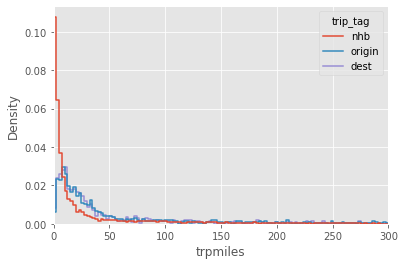

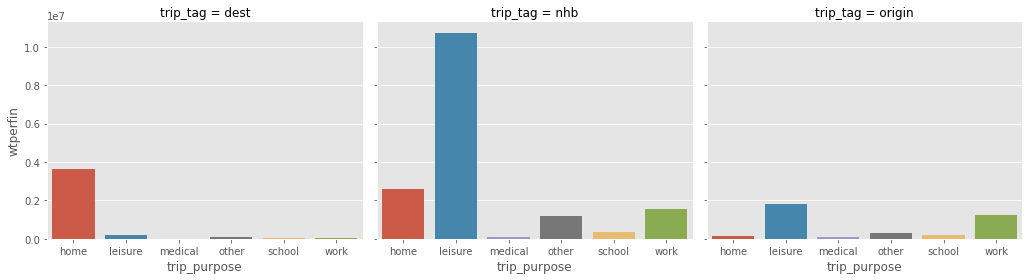

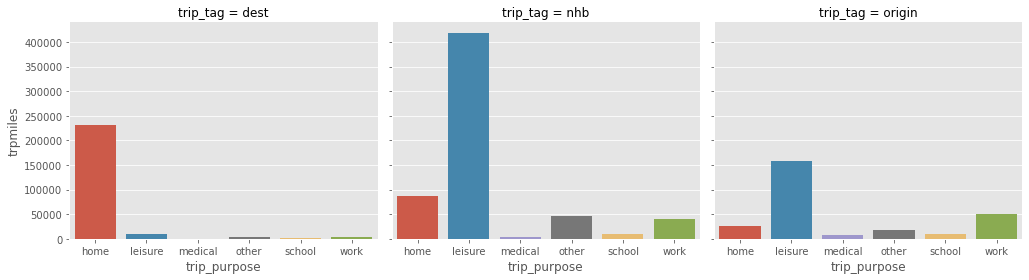

In [15]:
print(spillover_auto_trip_df.groupby('trip_tag').size())
print(spillover_auto_trip_df.groupby('trip_tag')['wtperfin'].sum())
print(spillover_auto_trip_df.groupby('trip_purpose')['wtperfin'].sum())
spillover_auto_trip_df.loc[:, 'wt_miles'] = \
spillover_auto_trip_df.loc[:, 'trpmiles'] * spillover_auto_trip_df.loc[:, 'wtperfin']
print(spillover_auto_trip_df.groupby('trip_tag')['wt_miles'].sum())
# spillover_auto_trip_df = spillover_auto_trip_df.reset_index()
sns.histplot(spillover_auto_trip_df, x="trpmiles", 
             hue = "trip_tag", element="step", fill=False, stat = 'density',
             common_norm = False)
plt.xlim([0, 300])
plt.savefig(supplement_data_dir + '/trip_distance_spillover.png', dpi = 200)
# plt.ylim([0, 0.03])
plt.show()

trip_count_by_purpose = \
spillover_auto_trip_df.groupby(['trip_tag','trip_purpose'])[['wtperfin', 'trpmiles']].sum()
trip_count_by_purpose = trip_count_by_purpose.reset_index()
sns.catplot(
    data=trip_count_by_purpose, 
    x = "trip_purpose", 
    y = "wtperfin", 
    col = "trip_tag", 
    kind = 'bar', height=4, aspect=1.2,
)
plt.savefig(supplement_data_dir + '/spillover_trip_purpose.png', dpi = 200)

sns.catplot(
    data=trip_count_by_purpose, 
    x = "trip_purpose", 
    y = "trpmiles", 
    col = "trip_tag", 
    kind = 'bar', height=4, aspect=1.2,
)
plt.savefig(supplement_data_dir + '/spillover_vmt_trip_purpose.png', dpi = 200)
# plt.xticks(rotation = 60)

In [16]:
# drop original home micro-geotype (as they are wrong)
national_geoid_lookup_short = \
national_geoid_lookup[['GEOID', 'geotype', 'microtype']]
spillover_auto_trip_df = \
spillover_auto_trip_df.drop(columns = ['geotype', 'microtype'])
spillover_auto_trip_df = pd.merge(spillover_auto_trip_df, 
                                  national_geoid_lookup_short,
                            left_on = 'home_geoid', right_on = 'GEOID',
                            how = 'left')
spillover_auto_trip_df.head(5)

,houseid,personid,tdtrpnum,trptrans,home_geoid,spatial_id,fips_st,st_code,state,cty,...,orig_microtype,orig_geoid,dest_st_code,dest_state,orig_st_code,orig_state,wt_miles,GEOID,geotype,microtype
0,30000401,1,1,5,3.001300e+10,24500,30,MT,Montana,30013,...,2,8035014503,CO,Colorado,CO,Colorado,61494.833147,3.001300e+10,B,2.0
1,30000401,1,2,5,3.001300e+10,24500,30,MT,Montana,30013,...,2,8059011602,CO,Colorado,CO,Colorado,26290.565366,3.001300e+10,B,2.0
2,30000401,1,3,5,3.001300e+10,24500,30,MT,Montana,30013,...,5,8005005612,CO,Colorado,CO,Colorado,43851.365139,3.001300e+10,B,2.0
3,30000401,1,4,5,3.001300e+10,24500,30,MT,Montana,30013,...,3,8035014503,CO,Colorado,CO,Colorado,5900.445257,3.001300e+10,B,2.0
4,30000401,1,5,5,3.001300e+10,24500,30,MT,Montana,30013,...,5,8035014504,CO,Colorado,CO,Colorado,5859.111140,3.001300e+10,B,2.0


In [17]:
# home-based trip generation rate
home_based_spillover_trips = \
spillover_auto_trip_df.loc[spillover_auto_trip_df['trip_tag'] != 'nhb']
home_based_spillover_trips.to_csv(supplement_data_dir + 'NHTS_home_based_spillover_trips.csv')
print(len(home_based_spillover_trips))

population_by_tract_national = population_trips.groupby(['geotype', 
                               'microtype', 'populationGroupType'])[['wthhfin']].sum()
population_by_tract_national.columns =['NHTS_households']
population_by_tract_national = population_by_tract_national.reset_index()


grouping_var = ['geotype', 'microtype', 'populationGroupType',
                'dest_geotype','dest_microtype',  
                'trip_tag', 'trip_purpose']
                               
home_based_trips_agg = home_based_spillover_trips.groupby(grouping_var)[['wtperfin']].sum()
home_based_trips_agg.columns = ['NHTS_trips']
home_based_trips_agg = home_based_trips_agg.loc[home_based_trips_agg['NHTS_trips'] > 0]
home_based_trips_agg = home_based_trips_agg.reset_index()
home_based_trips_agg = pd.merge(home_based_trips_agg, population_by_tract_national,
                                on = ['geotype', 'microtype', 'populationGroupType'],
                                how = 'left')
home_based_trips_agg.loc[:, 'trip_rate'] = \
home_based_trips_agg.loc[:, 'NHTS_trips'] / \
home_based_trips_agg.loc[:, 'NHTS_households']
home_based_trips_agg.to_csv(supplement_data_dir + 'NHTS_home_based_trip_rate_spillover.csv', index = False)          
home_based_trips_agg.head(5)

6126


,geotype,microtype,populationGroupType,dest_geotype,dest_microtype,trip_tag,trip_purpose,NHTS_trips,NHTS_households,trip_rate
0,A,1.0,high-income,A,3,dest,home,5931.238743,1.897001e+06,0.003127
1,A,1.0,high-income,B,1,origin,work,5480.206085,1.897001e+06,0.002889
2,A,1.0,high-income,B,3,dest,home,1201.573086,1.897001e+06,0.000633
3,A,1.0,high-income,B,3,origin,leisure,1470.084960,1.897001e+06,0.000775
4,A,1.0,high-income,B,4,dest,home,407.747933,1.897001e+06,0.000215


home VMT       6.346776e+08
nonhome VMT    4.608740e+08
dtype: float64
home VMT       6.346776e+08
nonhome VMT    4.608740e+08
dtype: float64
Index(['dest_geotype', 'dest_microtype', 'home VMT', 'o_geotype',
       'o_microtype', 'nonhome VMT', 'nhb_fraction_VMT'],
      dtype='object')


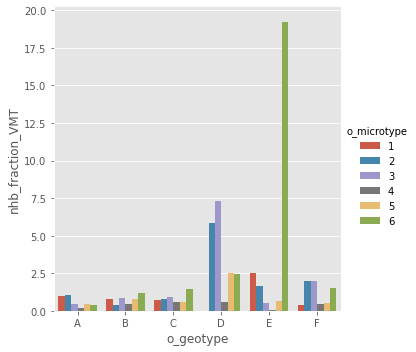

In [18]:
# non-home based trip
home_var = ['dest_geotype', 'dest_microtype']
home_based_spillover_trips.loc[:, 'VMT'] = \
home_based_spillover_trips.loc[:, 'trpmiles'] * \
home_based_spillover_trips.loc[:, 'wtperfin']
home_spillover_vmt = \
home_based_spillover_trips.groupby(home_var)[['VMT']].sum()
home_spillover_vmt.columns = ['home VMT']
home_spillover_vmt = home_spillover_vmt.reset_index()
# home_trips.head(5)

nonhome_based_spillover_trips = \
spillover_auto_trip_df.loc[spillover_auto_trip_df['trip_tag'] == 'nhb']
nonhome_based_spillover_trips = \
nonhome_based_spillover_trips.loc[nonhome_based_spillover_trips['trpmiles'] <= 300]
nonhome_var = ['o_geotype', 'o_microtype']
nonhome_based_spillover_trips.loc[:, 'VMT'] = \
nonhome_based_spillover_trips.loc[:, 'trpmiles'] * \
nonhome_based_spillover_trips.loc[:, 'wtperfin']
nonhome_spillover_vmt = \
nonhome_based_spillover_trips.groupby(nonhome_var)[['VMT']].sum()
nonhome_spillover_vmt.columns = ['nonhome VMT']
nonhome_spillover_vmt = nonhome_spillover_vmt.reset_index()
# nonhome_trips.head(5)

nonhome_fraction = pd.merge(home_spillover_vmt, nonhome_spillover_vmt,
                            left_on = home_var, 
                            right_on = nonhome_var, 
                            how = 'left')
print(nonhome_fraction[['home VMT', 'nonhome VMT']].sum())
nonhome_fraction = nonhome_fraction.loc[(nonhome_fraction['home VMT'] > 0) & (nonhome_fraction['nonhome VMT'] > 0)]
print(nonhome_fraction[['home VMT', 'nonhome VMT']].sum())
nonhome_fraction.loc[:, 'nhb_fraction_VMT'] = nonhome_fraction.loc[:, 'nonhome VMT'] / \
nonhome_fraction.loc[:, 'home VMT']
print(nonhome_fraction.columns)
# nonhome_fraction.head(5)
sns.catplot(data = nonhome_fraction, x = 'o_geotype', 
            y = 'nhb_fraction_VMT', hue = 'o_microtype', kind = 'bar')
plt.savefig('plot/mode_choice/nhb_fraction_o_micro_getoype.png', dpi = 200)
nonhome_fraction = nonhome_fraction[['o_geotype', 'o_microtype', 'nhb_fraction_VMT']]
nonhome_fraction.to_csv(supplement_data_dir + 'NHTS_nonhome_VMT_fraction_spillover.csv', index = False)

In [19]:
# non-home based trip (O-D only)
nonhome_based_spillover_OD = \
nonhome_based_spillover_trips[['o_geoid', 'orig_st_code', 
                               'd_geoid', 'dest_st_code', 
                               'trpmiles', 'wtperfin']]
nonhome_based_spillover_OD.to_csv(supplement_data_dir + 'NHTS_nonhome_OD_spillover.csv', index = False)